In [27]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


In [8]:
# Entangled circuit - bell states

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.save_density_matrix()



def bell_circuit():
    return qc

qc.draw('text')



┌───┐      density_matrix 
q_0: ┤ H ├──■─────────░────────
     └───┘┌─┴─┐       ░        
q_1: ─────┤ X ├───────░────────
          └───┘       ░

The following entagled states is the resulting state

|Φ+> = (|00> + |11>) / √2

since Entanglement is fragile we can study noise perfectly using theese kind of states

In [9]:
#defining an ideal state - which means no noise...

ideal_sim = AerSimulator(method = 'density_matrix')
qc_ideal = bell_circuit()

ideal_result = ideal_sim.run(transpile(qc_ideal, ideal_sim)).result()

rho_ideal = ideal_result.data(0)["density_matrix"]


we use a noiseless channel as our refference.

In [15]:
#Non - Pauli Noise

noise_model =NoiseModel()

error_1q = depolarizing_error(0.02,1)
error_2q = depolarizing_error(0.05,2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

noisy_sim = AerSimulator(method = "density_matrix", noise_model = noise_model)


In [17]:
#Run without pauli Twirling

qc_noisy = bell_circuit()
result_noisy = noisy_sim.run( transpile(qc_noisy, noisy_sim)).result()

rho_noisy = result_noisy.data(0)["density_matrix"]                                        

In [28]:
#Pauli Twirling

paulis = [ "i","x","y","z"]
twirled_states = []

for p in paulis:
    qc_t = QuantumCircuit(2)

    if p != 'i':
        getattr(qc_t, p)(0)

    qc_t.h(0)
    qc_t.cx(0,1)

    if p != 'i':
        getattr(qc_t, p)(0)

    qc_t.save_density_matrix()

    result = noisy_sim.run( transpile(qc_t, noisy_sim)).result()

    twirled_states.append(result.data(0)['density_matrix'])

rho_twirled = DensityMatrix(np.mean([rho.data for rho in twirled_states],axis = 0))
        

Explenation: Twoconsective same Pauli gates cancel out because X^2 = Y^2 = Z^2 = I. 
    
so we apppli pauli gate before and after the channel.
    
If channel is ideal itdoesnot makeany changes

In [30]:
#Fidelity Comparison

fid_raw = state_fidelity(rho_ideal, rho_noisy)
fid_twirled = state_fidelity(rho_ideal, rho_twirled)

print("Raw noise fidelity: ", fid_raw)
print("Twirled noise fidelity: ", fid_twirled)

Raw noise fidelity:  0.9530000013257517
Twirled noise fidelity:  0.25000000228898955


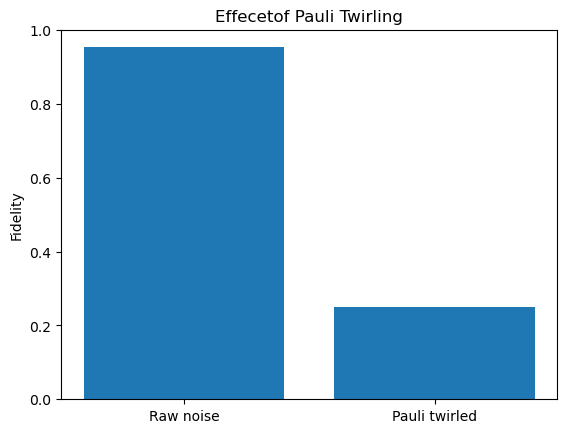

In [31]:
#vizulization

plt.bar(['Raw noise', 'Pauli twirled'], [ fid_raw, fid_twirled])
plt.ylabel("Fidelity")
plt.title("Effecetof Pauli Twirling")
plt.show()

In [35]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Build Bell circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.save_density_matrix()

# Ideal state
sim = AerSimulator(method="density_matrix")
ideal = sim.run(transpile(qc, sim)).result()
rho_ideal = ideal.data(0)["density_matrix"]

# Noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['cx'])

noisy_sim = AerSimulator(method="density_matrix", noise_model=noise_model)

# Raw noisy state
raw = noisy_sim.run(transpile(qc, noisy_sim)).result()
rho_raw = raw.data(0)["density_matrix"]

# Pauli twirling (correct 2-qubit)
paulis = ['i', 'x', 'y', 'z']
twirled_states = []

for p1 in paulis:
    for p2 in paulis:
        qc_t = QuantumCircuit(2)

        if p1 != 'i': getattr(qc_t, p1)(0)
        if p2 != 'i': getattr(qc_t, p2)(1)

        qc_t.h(0)
        qc_t.cx(0, 1)

        if p1 != 'i': getattr(qc_t, p1)(0)
        if p2 != 'i': getattr(qc_t, p2)(1)

        qc_t.save_density_matrix()
        result = noisy_sim.run(transpile(qc_t, noisy_sim)).result()
        twirled_states.append(result.data(0)["density_matrix"])

rho_twirled = DensityMatrix(np.mean(twirled_states, axis=0))

# Print debug info
print("Raw trace:", np.trace(rho_raw))
print("Twirled trace:", np.trace(rho_twirled.data))
print("Ideal fidelity:", state_fidelity(rho_ideal, rho_ideal))
print("Raw fidelity:", state_fidelity(rho_ideal, rho_raw))
print("Twirled fidelity:", state_fidelity(rho_ideal, rho_twirled))
print("Raw density matrix (first 2 rows):")
print(rho_raw[:2,:2])
print("Twirled density matrix (first 2 rows):")
print(rho_twirled.data[:2,:2])

Raw trace: (1.0000000000000002+0j)
Twirled trace: (1.0000000000000004+0j)
Ideal fidelity: 1.0000000000000022
Raw fidelity: 0.9530000013257517
Twirled fidelity: 0.25000000228898955
Raw density matrix (first 2 rows):
[[0.4875+0.j 0.    +0.j]
 [0.    +0.j 0.0125+0.j]]
Twirled density matrix (first 2 rows):
[[ 2.50000000e-01+0.00000000e+00j -2.60208521e-18+4.33680869e-19j]
 [-1.73472348e-18-6.93889390e-18j  2.50000000e-01+0.00000000e+00j]]


C:\Users\Isitha\AppData\Local\Temp\ipykernel_18804\781053105.py:59: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print(rho_raw[:2,:2])


The Above observation cannot be True. It seems like the state gets destroyed and ended up in a completely mixed state:

In [ ]:
The above wrong outcomes were 

In [36]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Build Bell circuit
def bell_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    qc.save_density_matrix()
    return qc

# Ideal simulator
ideal_sim = AerSimulator(method="density_matrix")

# Noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 2), ['cx'])
noisy_sim = AerSimulator(method="density_matrix", noise_model=noise_model)

paulis = ['i', 'x', 'y', 'z']

# --- Raw fidelity ---
ideal = ideal_sim.run(transpile(bell_circuit(), ideal_sim)).result()
rho_ideal = ideal.data(0)["density_matrix"]

raw = noisy_sim.run(transpile(bell_circuit(), noisy_sim)).result()
rho_raw = raw.data(0)["density_matrix"]

fid_raw = state_fidelity(rho_ideal, rho_raw)

# --- Twirled fidelity (correct average over Pauli ensemble) ---
fidelities = []

for p1 in paulis:
    for p2 in paulis:
        qc = QuantumCircuit(2)

        # apply random Pauli BEFORE circuit
        if p1 != 'i': getattr(qc, p1)(0)
        if p2 != 'i': getattr(qc, p2)(1)

        qc.h(0)
        qc.cx(0, 1)

        # apply same Pauli AFTER circuit
        if p1 != 'i': getattr(qc, p1)(0)
        if p2 != 'i': getattr(qc, p2)(1)

        qc.save_density_matrix()

        # ideal state for this Pauli pair
        ideal_result = ideal_sim.run(transpile(qc, ideal_sim)).result()
        rho_ideal_p = ideal_result.data(0)["density_matrix"]

        # noisy state for this Pauli pair
        noisy_result = noisy_sim.run(transpile(qc, noisy_sim)).result()
        rho_noisy_p = noisy_result.data(0)["density_matrix"]

        fidelities.append(state_fidelity(rho_ideal_p, rho_noisy_p))

fid_twirled = np.mean(fidelities)

print("Raw fidelity:", fid_raw)
print("Twirled fidelity (correct):", fid_twirled)

Raw fidelity: 0.9530000013257517
Twirled fidelity (correct): 0.9577500011650215


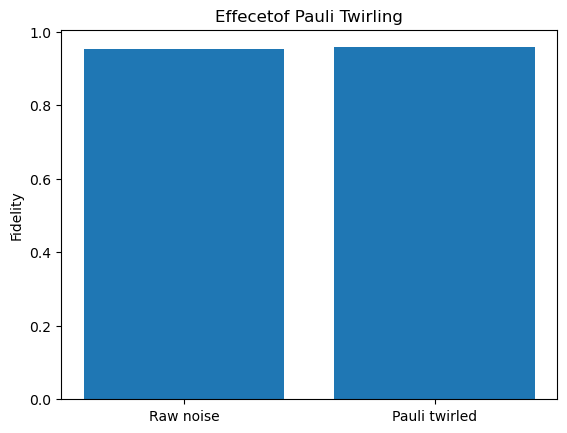

In [37]:

plt.bar(['Raw noise', 'Pauli twirled'], [ fid_raw, fid_twirled])
plt.ylabel("Fidelity")
plt.title("Effecetof Pauli Twirling")
plt.show()